In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### **LIBRERIE**

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import random
import os
import tensorflow as tf
from PIL import Image
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [ ]:
%cd /gdrive/MyDrive/ANN

/gdrive/MyDrive/ANN


In [ ]:
#Extracting the zipped archive into the folder in which I am 

!unzip /gdrive/MyDrive/ANN/leaves_test_overUnder_sampled.zip 

Archive:  /gdrive/MyDrive/ANN/leaves_test_overUnder_sampled.zip
replace leaves_test_overUnder_sampled/train/Apple/00481.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#**DATASET**

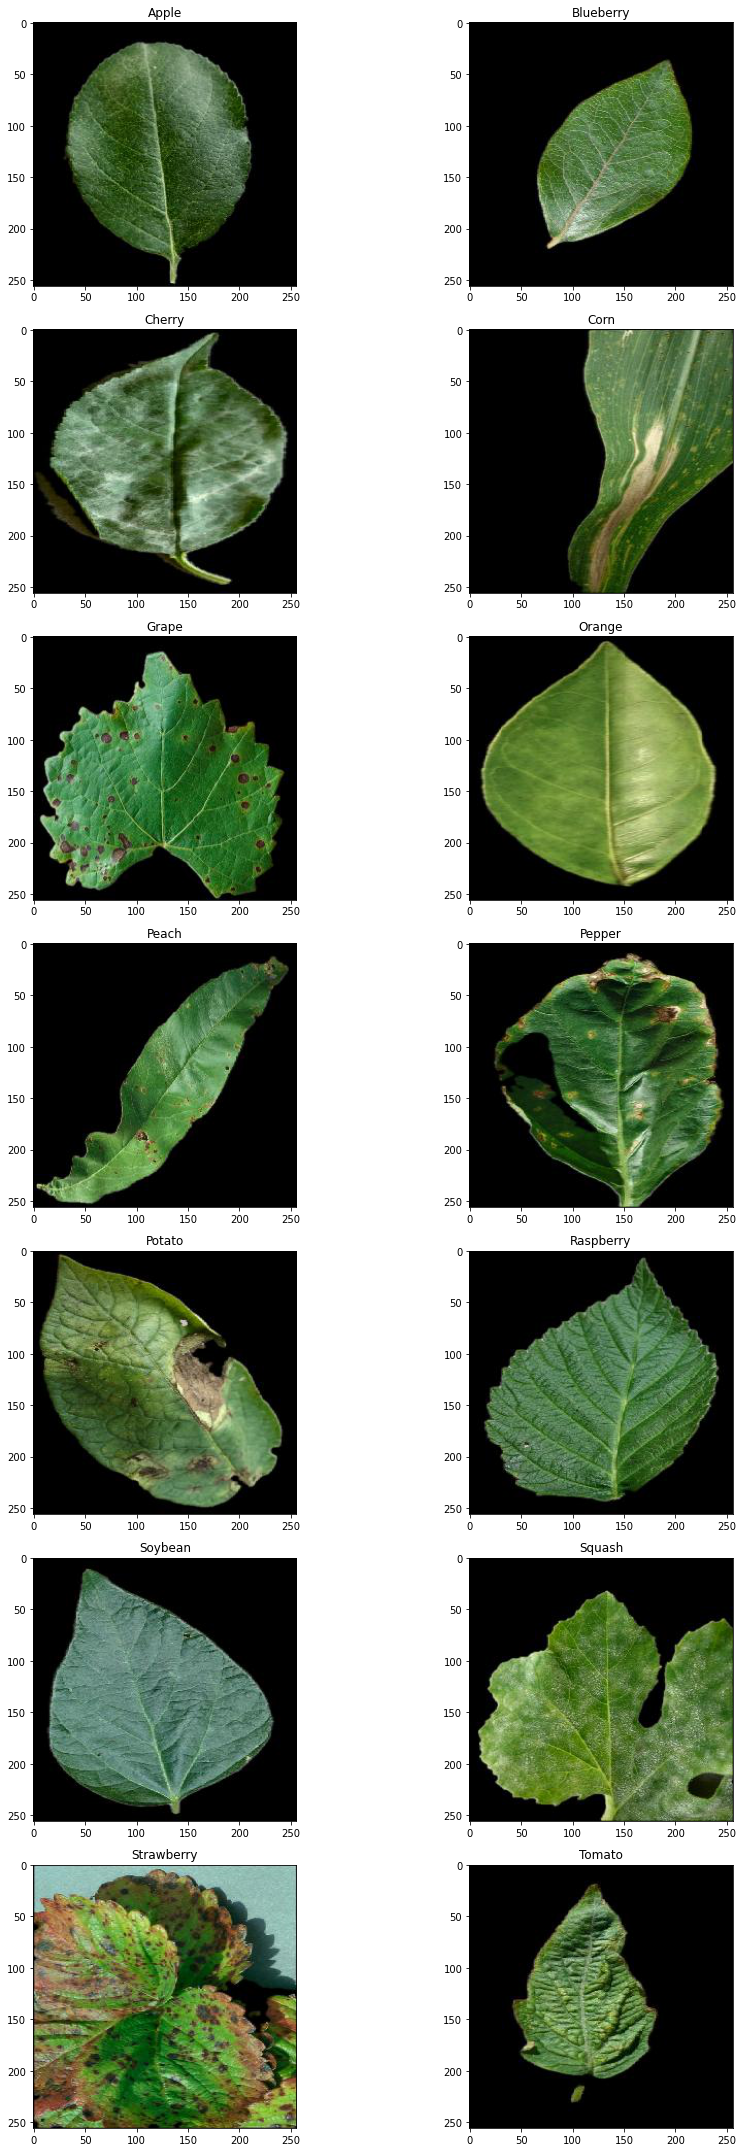

In [ ]:
dataset_dir = '/gdrive/MyDrive/ANN/leaves_test_overUnder_sampled' 

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test') 

# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

from tensorflow.keras.utils import to_categorical



num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()


In [ ]:
# Inspect dataset structure on disk
print("Depth 0 (UCMerced_LandUse")
print("-------")
!ls leaves_test_overUnder_sampled
print()
print("Depth 1 (e.g., leaves_test_overUnder_sampled/train)")
print("------------------------")
!ls leaves_test_overUnder_sampled/train
print()
print("Depth 2 (e.g., leaves_test_overUnder_sampled/trai/Apple)")
print("----------------------------")
!ls leaves_test_overUnder_sampled/train/Apple


Depth 0 (UCMerced_LandUse
-------
test  train  val

Depth 1 (e.g., leaves_test_overUnder_sampled/train)
------------------------
Apple	   Cherry  Grape   Peach   Potato     Soybean  Strawberry
Blueberry  Corn    Orange  Pepper  Raspberry  Squash   Tomato

Depth 2 (e.g., leaves_test_overUnder_sampled/trai/Apple)
----------------------------
00003.jpg  00166.jpg  00347.jpg  00524.jpg  22455.jpg  22641.jpg  22833.jpg
00006.jpg  00170.jpg  00348.jpg  00526.jpg  22456.jpg  22642.jpg  22834.jpg
00007.jpg  00172.jpg  00349.jpg  00527.jpg  22457.jpg  22643.jpg  22835.jpg
00011.jpg  00175.jpg  00351.jpg  00528.jpg  22458.jpg  22645.jpg  22837.jpg
00012.jpg  00177.jpg  00354.jpg  00529.jpg  22461.jpg  22646.jpg  22838.jpg
00013.jpg  00183.jpg  00357.jpg  00530.jpg  22472.jpg  22649.jpg  22840.jpg
00017.jpg  00185.jpg  00358.jpg  00531.jpg  22479.jpg  22650.jpg  22848.jpg
00018.jpg  00188.jpg  00359.jpg  00532.jpg  22480.jpg  22653.jpg  22849.jpg
00022.jpg  00189.jpg  00360.jpg  00533.jpg  22483.

Text(0.5, 1.0, 'Number of training images per category:')

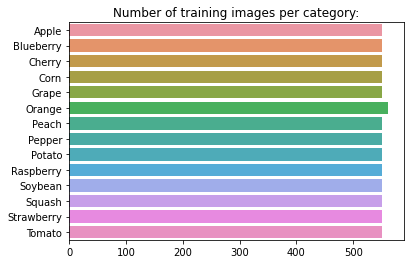

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 7711 images belonging to 14 classes.
Found 3500 images belonging to 14 classes.
Found 1785 images belonging to 14 classes.


# **SHOW EXAMPLE IMAGE**

In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[2]
  target = target[2]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (8, 256, 256, 3)
Target shape: (8, 14)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Label: 9
Class name: Raspberry


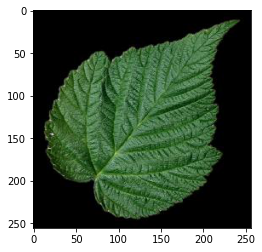

In [ ]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

###**DATA AUGMENTATION**

**SETS**

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. non worka con vgg16
                                        ) # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [ ]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 7711 images belonging to 14 classes.
Found 3500 images belonging to 14 classes.
Found 1785 images belonging to 14 classes.


#**CALLBACKS**

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('transfer_learning_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

### **Transfer learning**

In [ ]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')


base_model = tfk.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

inputs = tfk.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = tfk.layers.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)

tl_model = tfk.Model(inputs, output_layer)

tl_model.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics= 'accuracy')
tl_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 Flattening (Flatten)        (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                              

### Models metadata

In [ ]:
# Train the model
tl_history = tl_model.fit(x = aug_train_gen, epochs=200, callbacks=tl_callbacks, validation_data=valid_gen)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/200
241/241 [==============================] - ETA: 0s - loss: 1.5172 - accuracy: 0.5876

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 240s 860ms/step - loss: 1.5172 - accuracy: 0.5876 - val_loss: 0.6240 - val_accuracy: 0.8060
Epoch 2/200
241/241 [==============================] - ETA: 0s - loss: 0.8963 - accuracy: 0.7111

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 206s 855ms/step - loss: 0.8963 - accuracy: 0.7111 - val_loss: 0.5644 - val_accuracy: 0.8243
Epoch 3/200
241/241 [==============================] - ETA: 0s - loss: 0.7809 - accuracy: 0.7494

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 201s 834ms/step - loss: 0.7809 - accuracy: 0.7494 - val_loss: 0.4388 - val_accuracy: 0.8560
Epoch 4/200
241/241 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.7610

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 205s 849ms/step - loss: 0.7352 - accuracy: 0.7610 - val_loss: 0.4452 - val_accuracy: 0.8543
Epoch 5/200
241/241 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.7721

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 201s 836ms/step - loss: 0.7055 - accuracy: 0.7721 - val_loss: 0.3790 - val_accuracy: 0.8834
Epoch 6/200
241/241 [==============================] - ETA: 0s - loss: 0.6362 - accuracy: 0.7921

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 191s 792ms/step - loss: 0.6362 - accuracy: 0.7921 - val_loss: 0.3619 - val_accuracy: 0.8877
Epoch 7/200
241/241 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.7943

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 778ms/step - loss: 0.6484 - accuracy: 0.7943 - val_loss: 0.3279 - val_accuracy: 0.9029
Epoch 8/200
241/241 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.8051

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 188s 780ms/step - loss: 0.5994 - accuracy: 0.8051 - val_loss: 0.3243 - val_accuracy: 0.9034
Epoch 9/200
241/241 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.8098

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 189s 783ms/step - loss: 0.5956 - accuracy: 0.8098 - val_loss: 0.3547 - val_accuracy: 0.8969
Epoch 10/200
241/241 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.8219

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 774ms/step - loss: 0.5618 - accuracy: 0.8219 - val_loss: 0.2856 - val_accuracy: 0.9091
Epoch 11/200
241/241 [==============================] - ETA: 0s - loss: 0.5432 - accuracy: 0.8282

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 192s 796ms/step - loss: 0.5432 - accuracy: 0.8282 - val_loss: 0.2730 - val_accuracy: 0.9154
Epoch 12/200
241/241 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.8249

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 189s 785ms/step - loss: 0.5394 - accuracy: 0.8249 - val_loss: 0.2840 - val_accuracy: 0.9066
Epoch 13/200
241/241 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.8326

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 188s 781ms/step - loss: 0.5362 - accuracy: 0.8326 - val_loss: 0.2620 - val_accuracy: 0.9094
Epoch 14/200
241/241 [==============================] - ETA: 0s - loss: 0.4995 - accuracy: 0.8407

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 777ms/step - loss: 0.4995 - accuracy: 0.8407 - val_loss: 0.2694 - val_accuracy: 0.9114
Epoch 15/200
241/241 [==============================] - ETA: 0s - loss: 0.5267 - accuracy: 0.8331

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 189s 783ms/step - loss: 0.5267 - accuracy: 0.8331 - val_loss: 0.2758 - val_accuracy: 0.9066
Epoch 16/200
241/241 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.8400

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 188s 777ms/step - loss: 0.5026 - accuracy: 0.8400 - val_loss: 0.2772 - val_accuracy: 0.9189
Epoch 17/200
241/241 [==============================] - ETA: 0s - loss: 0.4955 - accuracy: 0.8435

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 186s 773ms/step - loss: 0.4955 - accuracy: 0.8435 - val_loss: 0.2613 - val_accuracy: 0.9160
Epoch 18/200
241/241 [==============================] - ETA: 0s - loss: 0.5061 - accuracy: 0.8387

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 777ms/step - loss: 0.5061 - accuracy: 0.8387 - val_loss: 0.2623 - val_accuracy: 0.9251
Epoch 19/200
241/241 [==============================] - ETA: 0s - loss: 0.4844 - accuracy: 0.8426

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 192s 794ms/step - loss: 0.4844 - accuracy: 0.8426 - val_loss: 0.2390 - val_accuracy: 0.9226
Epoch 20/200
241/241 [==============================] - ETA: 0s - loss: 0.4950 - accuracy: 0.8433

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 777ms/step - loss: 0.4950 - accuracy: 0.8433 - val_loss: 0.2286 - val_accuracy: 0.9286
Epoch 21/200
241/241 [==============================] - ETA: 0s - loss: 0.4938 - accuracy: 0.8465

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 777ms/step - loss: 0.4938 - accuracy: 0.8465 - val_loss: 0.2446 - val_accuracy: 0.9163
Epoch 22/200
241/241 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.8506

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 776ms/step - loss: 0.4831 - accuracy: 0.8506 - val_loss: 0.2625 - val_accuracy: 0.9186
Epoch 23/200
241/241 [==============================] - ETA: 0s - loss: 0.4613 - accuracy: 0.8529

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 776ms/step - loss: 0.4613 - accuracy: 0.8529 - val_loss: 0.2401 - val_accuracy: 0.9157
Epoch 24/200
241/241 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.8542

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 775ms/step - loss: 0.4589 - accuracy: 0.8542 - val_loss: 0.2584 - val_accuracy: 0.9177
Epoch 25/200
241/241 [==============================] - ETA: 0s - loss: 0.4709 - accuracy: 0.8505

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 775ms/step - loss: 0.4709 - accuracy: 0.8505 - val_loss: 0.2770 - val_accuracy: 0.9051
Epoch 26/200
241/241 [==============================] - ETA: 0s - loss: 0.4364 - accuracy: 0.8602

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 778ms/step - loss: 0.4364 - accuracy: 0.8602 - val_loss: 0.2516 - val_accuracy: 0.9263
Epoch 27/200
241/241 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.8484

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 776ms/step - loss: 0.4674 - accuracy: 0.8484 - val_loss: 0.2734 - val_accuracy: 0.9134
Epoch 28/200
241/241 [==============================] - ETA: 0s - loss: 0.4681 - accuracy: 0.8503

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 187s 775ms/step - loss: 0.4681 - accuracy: 0.8503 - val_loss: 0.2584 - val_accuracy: 0.9200
Epoch 29/200
241/241 [==============================] - ETA: 0s - loss: 0.4471 - accuracy: 0.8576

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 191s 792ms/step - loss: 0.4471 - accuracy: 0.8576 - val_loss: 0.2253 - val_accuracy: 0.9346
Epoch 30/200
241/241 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.8598

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 195s 808ms/step - loss: 0.4285 - accuracy: 0.8598 - val_loss: 0.2185 - val_accuracy: 0.9274
Epoch 31/200
241/241 [==============================] - ETA: 0s - loss: 0.4304 - accuracy: 0.8647

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 196s 812ms/step - loss: 0.4304 - accuracy: 0.8647 - val_loss: 0.2751 - val_accuracy: 0.9174
Epoch 32/200
241/241 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8545

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 197s 817ms/step - loss: 0.4583 - accuracy: 0.8545 - val_loss: 0.2221 - val_accuracy: 0.9286
Epoch 33/200
241/241 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.8659

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 197s 817ms/step - loss: 0.4337 - accuracy: 0.8659 - val_loss: 0.2333 - val_accuracy: 0.9331
Epoch 34/200
241/241 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.8529

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 198s 820ms/step - loss: 0.4699 - accuracy: 0.8529 - val_loss: 0.2115 - val_accuracy: 0.9357
Epoch 35/200
241/241 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8676

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 192s 797ms/step - loss: 0.4268 - accuracy: 0.8676 - val_loss: 0.2411 - val_accuracy: 0.9269
Epoch 36/200
241/241 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.8650

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 190s 788ms/step - loss: 0.4299 - accuracy: 0.8650 - val_loss: 0.2541 - val_accuracy: 0.9214
Epoch 37/200
241/241 [==============================] - ETA: 0s - loss: 0.4465 - accuracy: 0.8611

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


241/241 [==============================] - 192s 796ms/step - loss: 0.4465 - accuracy: 0.8611 - val_loss: 0.1703 - val_accuracy: 0.9483
Epoch 38/200
 56/241 [=====>........................] - ETA: 1:43 - loss: 0.4075 - accuracy: 0.8733

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the best model
tl_model.save('MAH')
#del tl_model  # To avoid filling the memory

In [ ]:

# Trained with data augmentation
model_noaug = tfk.models.load_model("MAH")
model_noaug_test_metrics = model_noaug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(model_noaug_test_metrics)


# **FINE TUNING**

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('FineFineTuning12')
ft_model.summary()

In [ ]:
# Set all VGG layers to True
ft_model.get_layer('xception').trainable = True
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = aug_train_gen ,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10,verbose= 2 , restore_best_weights=True)]
).history

In [ ]:
#Save the best model
ft_model.save('alpaca')
#del tl_model  # To avoid filling the memory

In [ ]:

# Trained with data augmentation
model_noaug = tfk.models.load_model("alpaca.h5")
model_noaug_test_metrics = model_noaug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(model_noaug_test_metrics)


56/56 [==============================] - 414s 7s/step - loss: 0.0556 - accuracy: 0.9882

Test metrics without data augmentation
{'loss': 0.05560099706053734, 'accuracy': 0.9882352948188782}


In [ ]:
model_noaug.save('XceptioFineTuning')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
